In [2]:
'''
imports
'''

#standard utilities
import pandas as pd
import numpy as np
import os
import random
import fastparquet
from collections import Counter
import re
import jamspell
import pickle


#nltk
import nltk
from nltk import TweetTokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')


#plots
import matplotlib.pyplot as plt
import seaborn as sns

#split datasets
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /home/leon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/leon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#train spellchecking model
corrector = jamspell.TSpellCorrector()
corrector.LoadLangModel('en.bin')

False

read in tweets, filter out NaNs or wrong entries in Sentiment column
use nltk's TweetTokenizer to preprocess tweets splitting them into words and removing capitalization

In [5]:
'''
Q1
'''
orig_path = "data/TweetsCOV19.csv"
proc_path = "data/TweetsCOV19_preprocessed.parquet"
proc_path_csv = "data/TweetsCOV19_preprocessed.csv"

random.seed(1234)

if os.path.exists(proc_path):
    df = pd.read_parquet(proc_path)

    with open('data/wl.pickle', 'rb') as file:
        wl_proc = pickle.load(file)
else:
    df = pd.read_csv(orig_path, usecols=['Sentiment', 'TweetText'], keep_default_na=False)
    #df = df.sample(10000)

    

    #filter out values with missing sentiment, split sentiment column
    filter_sentiment = re.compile(r'[1-5] -[1-5]')
    df = df[df.Sentiment.str.match(filter_sentiment)]
    df[['pos', 'neg']] = df.Sentiment.str.split(' ', expand=True)
    df[['pos', 'neg']] = df[['pos', 'neg']].astype(np.int8)


    prepr = 'prepr'
    df[prepr] = df['TweetText']
    #general filter using regex
    url_pattern = re.compile(r'https?://\S+')
    punctuation = re.compile(r'[^\w\s@]|(?<!@)@(?!\w)')
    latin_alphabet = re.compile(r'(?![a-zA-Z])[^\W\d_]+')
    extra_whitespace = re.compile(r' +')
    for p in [url_pattern, punctuation, latin_alphabet]:
        df[prepr] = df[prepr].str.replace(p, '', regex=True)


    spell_checker = lambda x : corrector.FixFragment(x)

    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True).tokenize

    stop_words = set(stopwords.words('english'))
    rem_stopwords = lambda tokens : [t for t in tokens if t not in stop_words]

    stemmer = PorterStemmer()
    stem = lambda tokens : [stemmer.stem(t) for t in tokens]

    lemmatizer = WordNetLemmatizer()
    lemmatize = lambda tokens : [lemmatizer.lemmatize(t) for t in tokens]

    for f in [spell_checker, tokenizer, rem_stopwords]:
        df[prepr] = df[prepr].apply(f)

   

    'llm' #return it to text
    df['llm'] = [' '.join(map(str, l)) for l in df[prepr]]
    df['llm'] = df['llm'].str.lower()
    df['llm'] = df['llm'].str.strip()
    df = df[~df['llm'].apply(lambda x: x.isspace() or x=="")]
    df['llm'] = df['llm'].str.replace(extra_whitespace, ' ', regex=True)
    
    

    'embedding' #spell checking
    df['embedding'] = df[prepr].apply(lemmatize)

    wl_proc = [word for tweet_tokens in df['embedding'] for word in tweet_tokens]
    with open('data/wl.pickle', 'wb') as file:
        pickle.dump(wl_proc, file, protocol=pickle.HIGHEST_PROTOCOL)
    
    

    #filter out words that appear less often than threshold
    word_2_appearances = Counter([word for tweet_tokens in df['embedding'] for word in tweet_tokens])
    threshold = 5
    words_we_keep = {k:c for k, c in word_2_appearances.items() if c >= threshold}
    df['embedding'] = df['embedding'].apply(lambda x : list(filter(lambda y : y in words_we_keep, x))) 
    df['embedding_str'] = [' '.join(map(str, l)) for l in df['embedding']]
    df['embedding_str'] = df['embedding_str'].str.lower()

    #drop strings that are only spaces
    #print(df.shape[0])
    df['embedding_str'] = df['embedding_str'].str.strip()
    df = df[~df['embedding_str'].apply(lambda x: x.isspace() or x=="")]
    df['embedding_str'] = df['embedding_str'].str.replace(extra_whitespace, ' ', regex=True)

    #print(df.shape[0])
    df.drop(prepr, axis=1, inplace=True)



    df.to_parquet(proc_path)
    df.to_csv(proc_path_csv)

In [6]:
#test if there is any empty columns
df = pd.read_csv(proc_path_csv)
print(df["embedding_str"].isnull().values.any())
print(df[df['embedding_str'].isna()])

print(df["llm"].isnull().values.any())
print(df[df['llm'].isna()])

False
Empty DataFrame
Columns: [Unnamed: 0, Sentiment, TweetText, pos, neg, llm, embedding, embedding_str]
Index: []
False
Empty DataFrame
Columns: [Unnamed: 0, Sentiment, TweetText, pos, neg, llm, embedding, embedding_str]
Index: []


In [7]:
#justification for cutoff
counter = Counter(wl_proc)

unique_words = list(set(wl_proc))

test_list = [5, 10, 15, 25, 50, 100, 1000, 10000]
test_list = [10000, 1000, 100, 50, 25, 15, 10, 5]

def ratio_to_percent(counter, denominator, rounding_digits = 2):
    return np.round(counter / denominator * 100, rounding_digits)

for threshold in test_list:
    higher_words = {k:c for k, c in counter.items() if c >= threshold}
    #print(len(higher_words))
    print(f"words appearing >={threshold} words: {ratio_to_percent(len([w for w in wl_proc if w in higher_words]), len(wl_proc))}%, unique words {ratio_to_percent(len(higher_words), len(unique_words))}%")
    print(f"words appearing <={threshold} words: {ratio_to_percent(len([w for w in wl_proc if w not in higher_words]), len(wl_proc))}% unique words {ratio_to_percent(len(list(set(wl_proc).difference(set(higher_words)))), len(unique_words))}%")

words appearing >=10000 words: 32.56%, unique words 0.03%
words appearing <=10000 words: 67.44% unique words 99.97%
words appearing >=1000 words: 67.48%, unique words 0.42%
words appearing <=1000 words: 32.52% unique words 99.58%
words appearing >=100 words: 87.26%, unique words 2.31%
words appearing <=100 words: 12.74% unique words 97.69%
words appearing >=50 words: 90.31%, unique words 3.57%
words appearing <=50 words: 9.69% unique words 96.43%
words appearing >=25 words: 92.55%, unique words 5.43%
words appearing <=25 words: 7.45% unique words 94.57%
words appearing >=15 words: 93.85%, unique words 7.43%
words appearing <=15 words: 6.15% unique words 92.57%
words appearing >=10 words: 94.74%, unique words 9.62%
words appearing <=10 words: 5.26% unique words 90.38%
words appearing >=5 words: 96.03%, unique words 15.32%
words appearing <=5 words: 3.97% unique words 84.68%


In [8]:
def words_in_filter_group(lower, upper, return_cnt=100):
    #wl_proc = [word for tweet_tokens in df['proc_no_filter'] for word in tweet_tokens]
    #print(wl_proc[0:10])

    counter = Counter(wl_proc)

    higher_words = {k:c for k, c in counter.items() if c >= lower and c <= upper}
    return list(higher_words.keys())[0:return_cnt]

print(words_in_filter_group(10, 10))

['terf', 'wingman', '344', 'happ', 'goptraitors', 'scribble', 'stimulant', 'uwus', 'reckons', 'smirking', 'cpl', 'opioidhysteria', 'painpatientsvote', 'sasse', 'mainer', 'svp', 'trimming', '2go', 'rector', 'bernardo', 'fantastical', 'cower', 'marcher', 'alastair', 'tescos', 'bkk', 'slipknot', 'ortiz', 'grover', 'thrissur', 'nakuru', 'urinal', 'swirling', 'enamel', 'herein', 'buckley', 'susanna', 'integrative', 'halper', 'druid', 'interchangeable', '67yearold', 'soso', '1320', 'yaani', 'shoutouts', 'standwithmorey', 'conveyor', 'enuf', 'dz', 'bootlicking', 'sud', 'eczema', 'mids', '2009201', 'analytica', 'leroy', 'rea', 'saxon', 'triplet', 'yll', 'foreignborn', 'rapline', 'gipper', 'avenge', '374', 'dekat', 'reliever', 'lpn', 'carver', 'zines', 'merike', 'ciao', 'enrique', 'algae', 'sff', 'floater', 'pulisic', 'sprained', 'remo', '1630', 'kickass', 'ampfw', 'teetering', 'htgawm', 'notimetodie', 'mexicogp', 'thots', 'dickinson', 'modernize', 'onside', 'moreys', 'harrassed', 'chara', 'aja

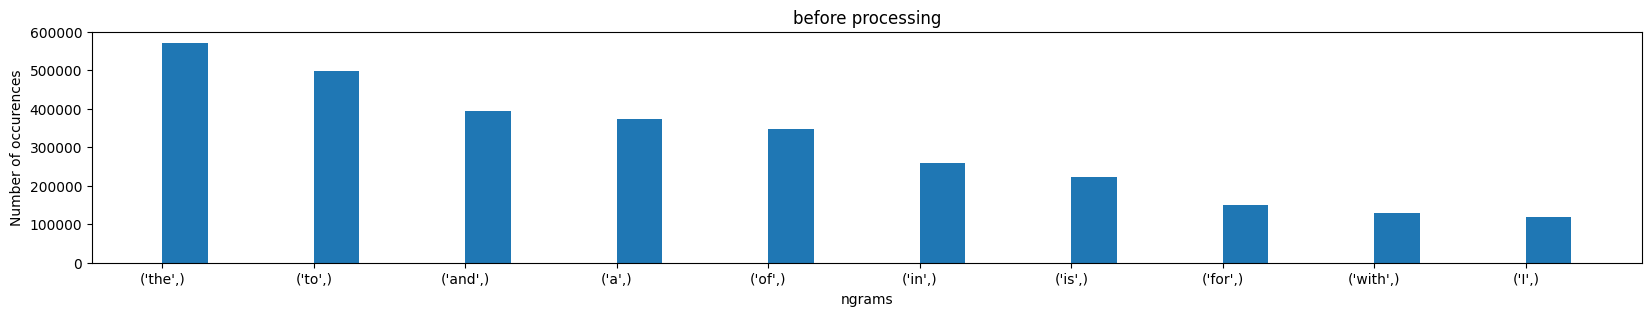

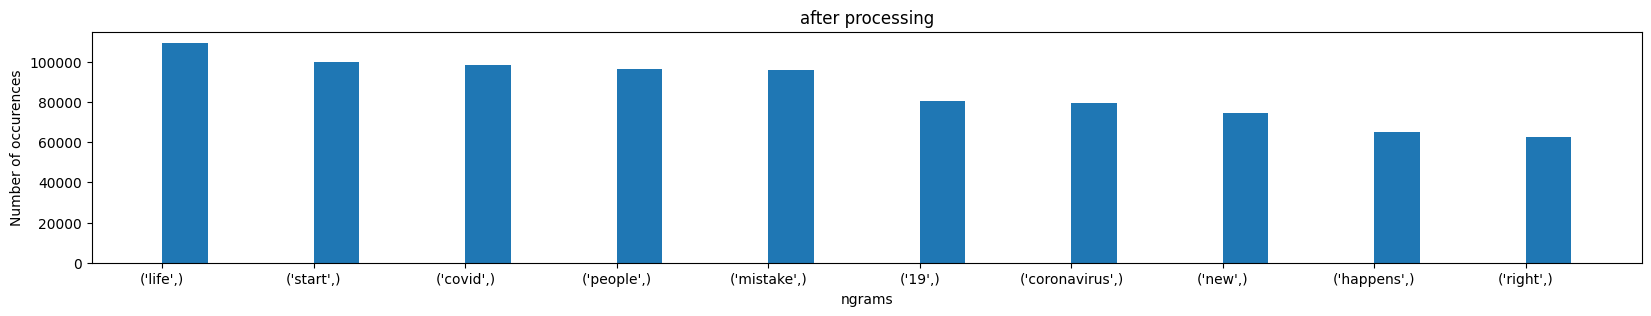

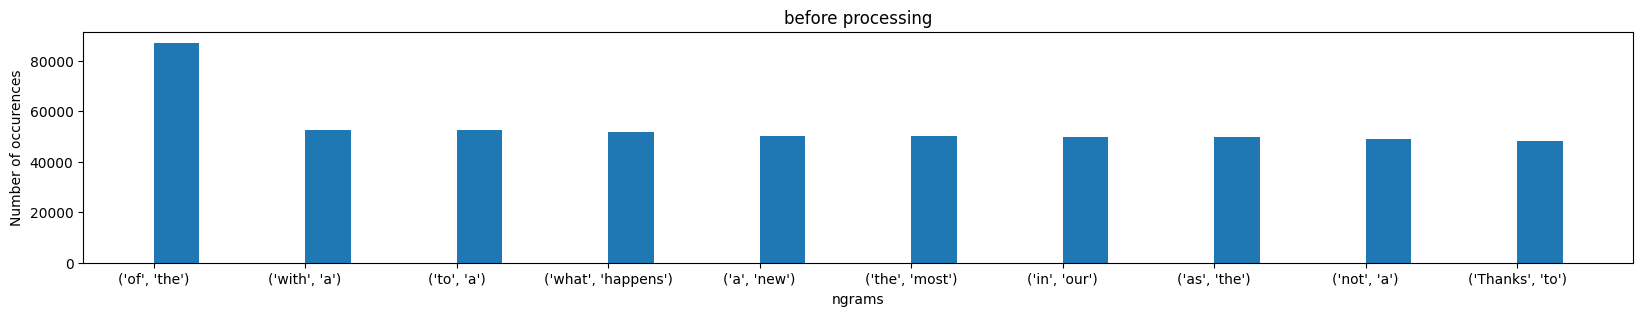

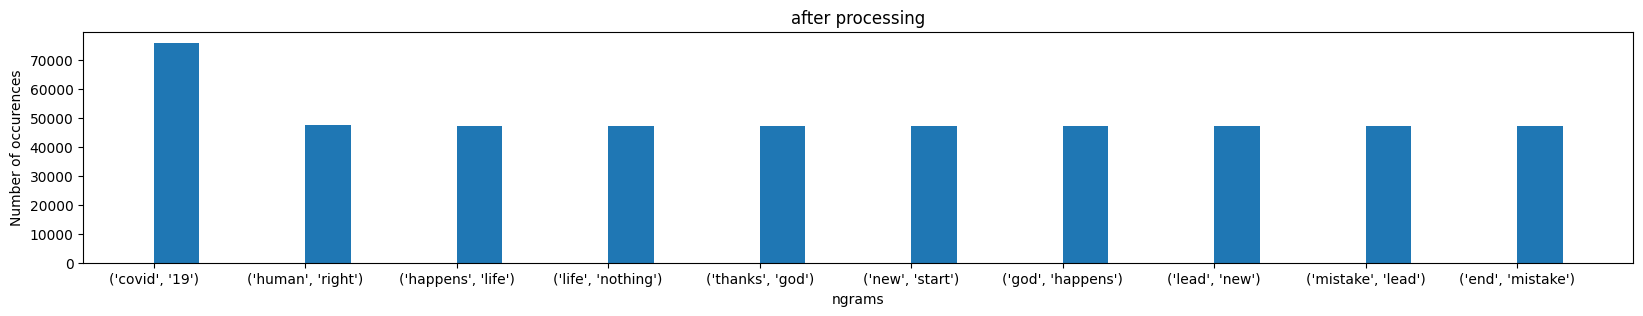

In [9]:
'''
Q2
'''
df = pd.read_parquet(proc_path)

wl = ' '.join(df['TweetText'].to_list()).split(" ")
#wl_proc = df['TweetText_proc'].sum()
wl = [wl, wl_proc]

grams = []
gram_counts = []
plot_top_n = 10
#yield the necessary combinations of indices
idxs_1 = [0,1,0,1] 
idxs_2 = [1,1,2,2]

names = ["before processing", "after processing"]

for i in range(4):    
    grams.append(ngrams(wl[idxs_1[i]], idxs_2[i]))
    ngram_counts = Counter(grams[i])
    gram_counts.append(ngram_counts.most_common(plot_top_n))
    
    x, y = list(zip(*gram_counts[i]))
    plt.figure(figsize=(20, 3))  # width:20, height:3
    plt.bar(range(len(y)), list(y), align='edge', width=0.3)
    plt.xticks(range(len(x)), list(x))
    plt.ylabel("Number of occurences")
    plt.xlabel("ngrams")
    plt.title(names[idxs_1[i]])
    plt.show()
    plt.close()



In [10]:
#how word distribution varies as function of sentiment labels
sentiment_pos = 5

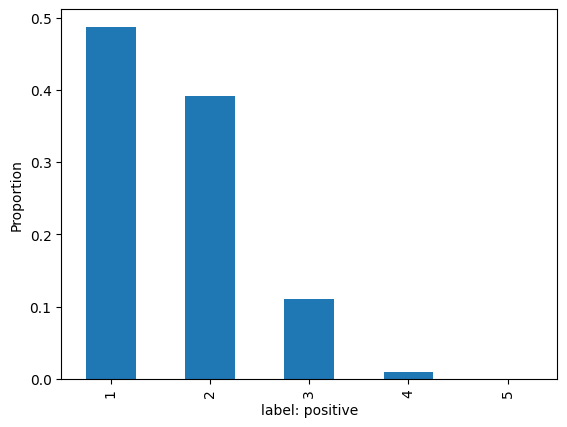

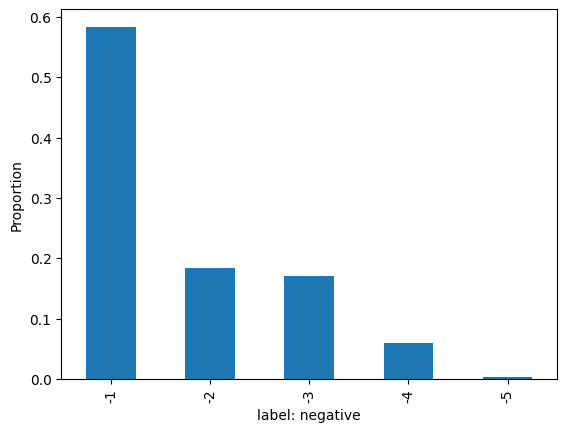

In [11]:
#proportion of each sentiment
for c in ["positive", "negative"]:
    df[c[0:3]].value_counts(normalize=True).plot(kind='bar')
    plt.xlabel("label: " + c)
    plt.ylabel("Proportion")
    plt.show()

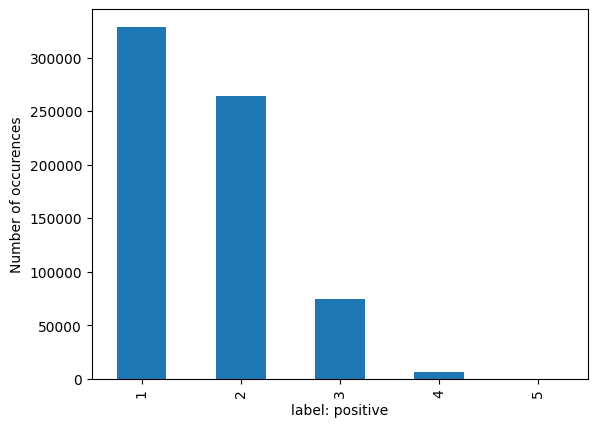

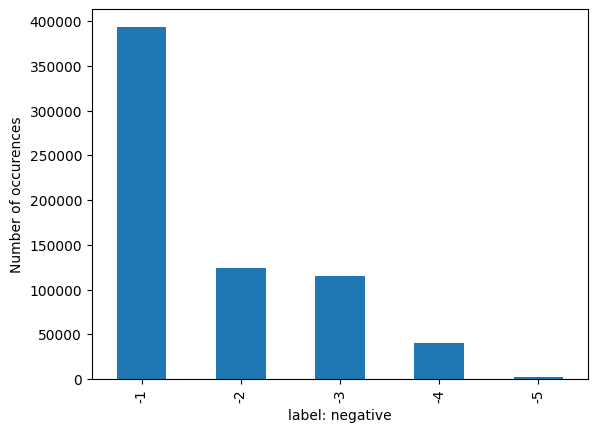

In [12]:
#are classes balanced?
for c in ["positive", "negative"]:
    df[c[0:3]].value_counts().plot(kind='bar')
    plt.xlabel("label: " + c)
    plt.ylabel("Number of occurences")
    plt.show()

In [18]:
#split into train validation and test set
dftr = pd.DataFrame() #train
dfvl = pd.DataFrame() #validation
dfte = pd.DataFrame() #test
dfti = pd.DataFrame() #intermediate split

#reducing dataframe size to increase training speed
seed = 1234
sample_size = 50000
df_sample = df.sample(sample_size, random_state=seed)

dftr["X"], dfti["X"], dftr["y"], dfti["y"] = train_test_split(df_sample['embedding_str'], df_sample["Sentiment"], test_size=0.2, random_state=seed)
dftr[["y_pos", "y_neg"]] = dftr["y"].str.split(' ', expand=True)
dftr[["y_pos", "y_neg"]] = dftr[["y_pos", "y_neg"]].astype(np.int8)
dftr.to_csv("data/train.csv")
dftr.to_parquet("data/train.parquet")

dfvl["X"], dfte["X"], dfvl["y"], dfte["y"] = train_test_split(dfti["X"], dfti["y"], test_size=0.5, random_state=seed)
dfte[["y_pos", "y_neg"]] = dfte["y"].str.split(' ', expand=True)
dfte[["y_pos", "y_neg"]] = dfte[["y_pos", "y_neg"]].astype(np.int8)
dfte.to_csv("data/test.csv")
dfte.to_parquet("data/test.parquet")
dfvl[["y_pos", "y_neg"]] = dfvl["y"].str.split(' ', expand=True)
dfvl[["y_pos", "y_neg"]] = dfvl[["y_pos", "y_neg"]].astype(np.int8)
dfvl.to_csv("data/valid.csv")
dfvl.to_parquet("data/valid.parquet")